In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob


In [34]:
Root_DIR = "Brain_Tumor_Detection"
number_of_image = {}

for dir in os.listdir(Root):
    dir_path = os.path.join(Root_DIR, dir)
    
    if os.path.isdir(dir_path):  
        number_of_image[dir] = len(os.listdir(dir_path))

number_of_image.items()



dict_items([('.ipynb_checkpoints', 0), ('no', 1500), ('pred', 60), ('yes', 1500)])

#Training / Validation / Testing.

In [35]:
import random

SOURCE_DIR = "Brain_Tumor_Detection"
DEST_DIR = "Brain_Tumor_Detection_Split"

CLASSES = ["yes", "no"]

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png")

random.seed(42)

for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

for cls in CLASSES:
    cls_path = os.path.join(SOURCE_DIR, cls)


    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith(IMG_EXTENSIONS)
        and os.path.isfile(os.path.join(cls_path, f))
    ]

    random.shuffle(images)

    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = train_end + int(total * VAL_RATIO)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    for img in train_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(DEST_DIR, "train", cls, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(DEST_DIR, "val", cls, img)
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(DEST_DIR, "test", cls, img)
        )

    print(f"{cls}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

print("Dataset split completed successfully!")


yes: Train=1050, Val=225, Test=225
no: Train=1049, Val=224, Test=226
Dataset split completed successfully!


In [ ]:
##Model Build

In [36]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model = Sequential([
    Input(shape=(224,224,3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.00005),  # LOWER LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
import keras

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocessingImages(path, augment=False):
    if augment:
        gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        gen = ImageDataGenerator(rescale=1./255)

    return gen.flow_from_directory(
        path,
        target_size=(224,224),
        batch_size=32,
        class_mode='binary'
    )


train_path = "Brain_Tumor_Detection_Split/train"
val_path   = "Brain_Tumor_Detection_Split/val"
test_path  = "Brain_Tumor_Detection_Split/test"

train_data = preprocessingImages(train_path, augment=True)
val_data   = preprocessingImages(val_path, augment=False)
test_data  = preprocessingImages(test_path, augment=False)


Found 2129 images belonging to 2 classes.
Found 449 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',        # more stable than accuracy
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_brain_tumor_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, model_checkpoint]


In [40]:
# Model training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7137 - loss: 0.5854 
Epoch 1: val_loss improved from inf to 0.21685, saving model to best_brain_tumor_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7152 - loss: 0.5829 - val_accuracy: 0.9399 - val_loss: 0.2168
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9134 - loss: 0.2309 
Epoch 2: val_loss did not improve from 0.21685
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 729ms/step - accuracy: 0.9133 - loss: 0.2310 - val_accuracy: 0.8441 - val_loss: 0.3244
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9243 - loss: 0.2033 
Epoch 3: val_loss did not improve from 0.21685
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 742ms/step - accuracy: 0.9244 - loss: 0.2030 - val_accuracy: 0.9020 - val_loss: 0.2250
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9316 - loss: 0.1739 
Epoch 4: val_loss improved from 0.21685 to 0.14066, saving model to best_brain_tumor_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 735ms/step - accuracy: 0.9316 - loss: 0.1737 - val_accuracy: 0.9599 - val_loss: 0.1407
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9463 - loss: 0.1508 
Epoch 5: val_loss did not improve from 0.14066
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 744ms/step - accuracy: 0.9462 - loss: 0.1508 - val_accuracy: 0.9577 - val_loss: 0.1434
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9590 - loss: 0.1061 
Epoch 6: val_loss improved from 0.14066 to 0.13987, saving model to best_brain_tumor_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 757ms/step - accuracy: 0.9591 - loss: 0.1060 - val_accuracy: 0.9376 - val_loss: 0.1399
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9646 - loss: 0.0950 
Epoch 7: val_loss improved from 0.13987 to 0.10270, saving model to best_brain_tumor_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 738ms/step - accuracy: 0.9645 - loss: 0.0951 - val_accuracy: 0.9644 - val_loss: 0.1027
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9662 - loss: 0.0932 
Epoch 8: val_loss did not improve from 0.10270
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 738ms/step - accuracy: 0.9662 - loss: 0.0933 - val_accuracy: 0.9465 - val_loss: 0.1255
Epoch 9/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9650 - loss: 0.0824 
Epoch 9: val_loss did not improve from 0.10270
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 729ms/step - accuracy: 0.9650 - loss: 0.0825 - val_accuracy: 0.9465 - val_loss: 0.1387
Epoch 10/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9758 - loss: 0.0759 
Epoch 10: val_loss did not improve from 0.10270
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 737ms/step - accuracy: 0.9758 - loss: 0.0759 - val_accuracy: 0.9532 - val_loss: 0.1232
Epoch 11/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9707 - loss: 0.0758 
Epoch 11: val_loss did not improve f

67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 759ms/step - accuracy: 0.9817 - loss: 0.0620 - val_accuracy: 0.9555 - val_loss: 0.1000
Epoch 13/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9754 - loss: 0.0747 
Epoch 13: val_loss did not improve from 0.10002
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 745ms/step - accuracy: 0.9754 - loss: 0.0747 - val_accuracy: 0.9555 - val_loss: 0.1174
Epoch 14/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9849 - loss: 0.0518 
Epoch 14: val_loss improved from 0.10002 to 0.08424, saving model to best_brain_tumor_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 752ms/step - accuracy: 0.9849 - loss: 0.0519 - val_accuracy: 0.9688 - val_loss: 0.0842
Epoch 15/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9847 - loss: 0.0522 
Epoch 15: val_loss did not improve from 0.08424
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 747ms/step - accuracy: 0.9846 - loss: 0.0523 - val_accuracy: 0.9666 - val_loss: 0.0943
Epoch 16/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9808 - loss: 0.0566 
Epoch 16: val_loss did not improve from 0.08424
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 736ms/step - accuracy: 0.9808 - loss: 0.0566 - val_accuracy: 0.9599 - val_loss: 0.1107
Epoch 17/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9805 - loss: 0.0573 
Epoch 17: val_loss did not improve from 0.08424
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 742ms/step - accuracy: 0.9806 - loss: 0.0572 - val_accuracy: 0.9644 - val_loss: 0.0859
Epoch 18/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9825 - loss: 0.0459 
Epoch 18: val_loss did not impro

67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 749ms/step - accuracy: 0.9770 - loss: 0.0540 - val_accuracy: 0.9800 - val_loss: 0.0779
Epoch 20/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9865 - loss: 0.0425 
Epoch 20: val_loss did not improve from 0.07795
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 742ms/step - accuracy: 0.9865 - loss: 0.0426 - val_accuracy: 0.9621 - val_loss: 0.1007
Epoch 21/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9877 - loss: 0.0401 
Epoch 21: val_loss did not improve from 0.07795
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 734ms/step - accuracy: 0.9877 - loss: 0.0402 - val_accuracy: 0.9733 - val_loss: 0.0837
Epoch 22/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9881 - loss: 0.0358 
Epoch 22: val_loss did not improve from 0.07795
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 741ms/step - accuracy: 0.9881 - loss: 0.0358 - val_accuracy: 0.9577 - val_loss: 0.1162
Epoch 23/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9786 - loss: 0.0422 
Epoch 23: val_loss did not impro

In [41]:
h = history.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

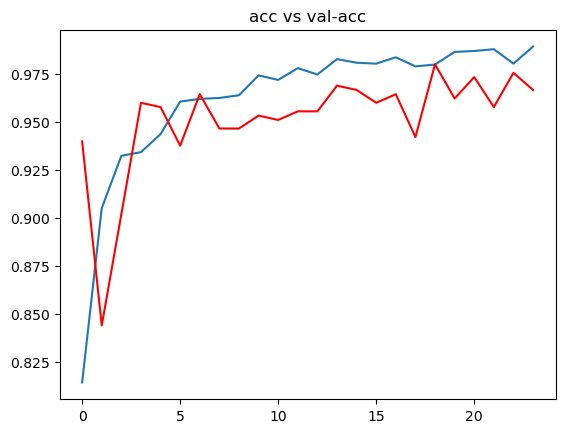

In [43]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title('acc vs val-acc')
plt.show()

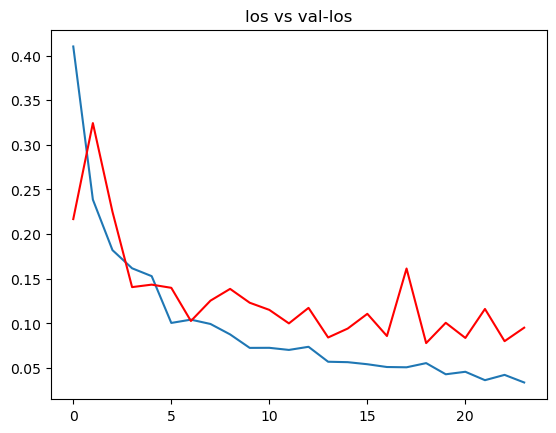

In [44]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")
plt.title('los vs val-los')
plt.show()

In [45]:
# Model accuracy
from tensorflow.keras.models import load_model

model = load_model('best_brain_tumor_model.h5')

loss, accuracy = model.evaluate(test_data, verbose=1)
print(f"The test accuracy of the model is: {accuracy:.4f}")



15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 749ms/step - accuracy: 0.9799 - loss: 0.0635
The test accuracy of the model is: 0.9800
